# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv.gz` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv.gz')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-I,no-book-author,57116,88383
1,BX-I,male,98030,467021
2,BX-I,no-author-rec,14005,23304
3,BX-I,unknown,34784,78089
4,BX-I,ambiguous,7143,81193


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,217855,491560,17832,239621,141257,1156610,NaN
BX-E,38080,56434,4212,17001,6875,28430,NaN
BX-I,67139,98030,7143,34784,14005,57116,NaN
GR-E,175690,279432,11656,96483,30127,891464,NaN
GR-I,177301,282823,11763,98253,30842,905429,NaN
LOC-MDS,666594,2212527,54208,1219129,272590,842812,NaN


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,4339336,6606737,610220,2093169,736395,8071511,NaN
BX-E,138487,184505,32744,27574,8759,34996,NaN
BX-I,390876,467021,81193,78089,23304,88383,NaN
GR-E,34586008,34900583,9315132,3973094,523795,16881739,NaN
GR-I,76091597,71254945,15123169,10502922,1487249,46539909,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.096194,0.217050,0.007874,0.105805,0.062372,0.510704,NaN
BX-E,0.252132,0.373656,0.027888,0.112566,0.045520,0.188238,NaN
BX-I,0.241319,0.352351,0.025674,0.125025,0.050338,0.205293,NaN
GR-E,0.118322,0.188188,0.007850,0.064978,0.020290,0.600372,NaN
GR-I,0.117698,0.187746,0.007809,0.065223,0.020474,0.601050,NaN
LOC-MDS,0.126540,0.420005,0.010290,0.231428,0.051746,0.159991,NaN


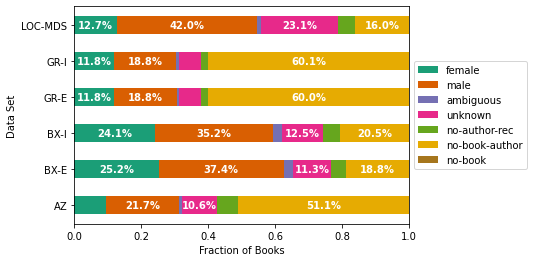

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.096194,0.217050,0.007874,0.105805,0.573077
BX-E,0.252132,0.373656,0.027888,0.112566,0.233758
BX-I,0.241319,0.352351,0.025674,0.125025,0.255631
GR-E,0.118322,0.188188,0.007850,0.064978,0.620662
GR-I,0.117698,0.187746,0.007809,0.065223,0.621524
LOC-MDS,0.126540,0.420005,0.010290,0.231428,0.211737


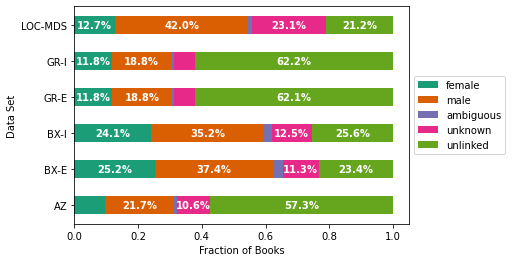

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

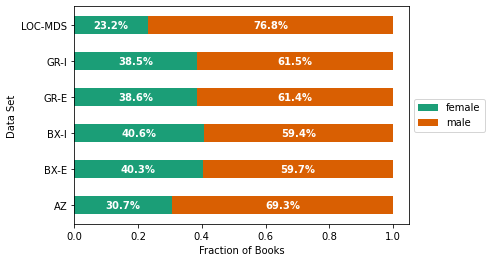

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.193225,0.294190,0.027172,0.093206,0.032791,0.359415,NaN
BX-E,0.324276,0.432030,0.076672,0.064566,0.020510,0.081945,NaN
BX-I,0.346255,0.413708,0.071924,0.069175,0.020644,0.078294,NaN
GR-E,0.345237,0.348378,0.092984,0.039659,0.005229,0.168513,NaN
GR-I,0.344306,0.322421,0.068431,0.047525,0.006730,0.210588,NaN


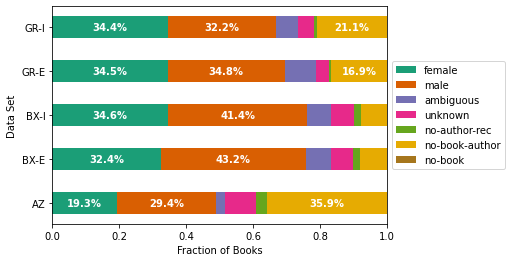

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.193225,0.294190,0.027172,0.093206,0.392206
BX-E,0.324276,0.432030,0.076672,0.064566,0.102455
BX-I,0.346255,0.413708,0.071924,0.069175,0.098937
GR-E,0.345237,0.348378,0.092984,0.039659,0.173742
GR-I,0.344306,0.322421,0.068431,0.047525,0.217318


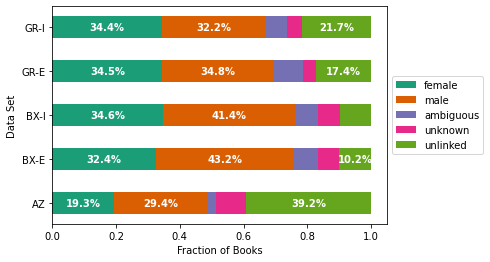

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

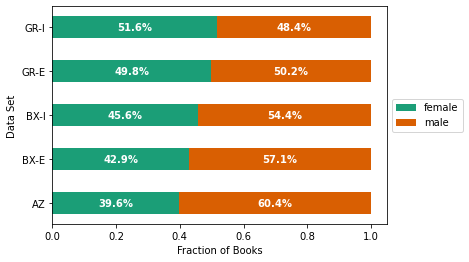

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))